In [1]:
# %% imports
# libraries
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.modules.activation import ReLU
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as plticker
import os

# local imports
import MNIST_dataloader
import AEarchitecture
from config_file import data_loc, batch_size
from MNIST_dataloader import *
import matplotlib.cm as cm

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()  # same as super().__init__()
        # how to find output shape: [input - kernel + 2*padding - (dilation-1)(kernel-1)]/stride + 1
        self.encoder = nn.Sequential(
            #  
            nn.Conv2d(1,16, kernel_size=(3,3),padding=1, stride=1), #[Nx1x32x32]=> [Nx16x32x32]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x32x32]=> [Nx16x16x16]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x16x16]=> [Nx16x16x16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x16x16]=> [Nx16x8x8]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x8x8]=> [Nx16x8x8]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x8x8]=> [Nx16x4x4]

            nn.Conv2d(16,16, kernel_size=(3,3),padding=1, stride=1), #[Nx16x4x4]=> [Nx16x4x4]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#[Nx16x4x4]=> [Nx16x2x2]
            nn.Flatten(), #[Nx16x2x2] -> [Nx64]
#             nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
#             nn.MaxPool2d(1) #[Nx1x2x2]=> [Nx1x2x2]            
            )
        
        self.mean = nn.Sequential(
            nn.Linear(16*2*2,16) #[Nx64] -> [Nx16]
            )
        
        self.var = nn.Sequential(
            nn.Linear(16*2*2,16) #[Nx64] -> [Nx16]
            )
        
        
        self.Normal_dist = torch.distributions.Normal(0, 1) # (mean, scale)
        if self.training:
            self.Normal_dist.loc = self.Normal_dist.loc.cuda() # hack to get sampling on the GPU
            self.Normal_dist.scale = self.Normal_dist.scale.cuda()
            if torch.cuda.is_available(): device = torch.device('cuda')
        else:
            device = torch.device("cpu")
        print("Encoder working on",device)
        
        self.kl = 0

#             nn.Conv2d(16,1, kernel_size=(3,3),padding=1, stride=1), #[Nx16x2x2]=> [Nx1x2x2]
#             nn.MaxPool2d((1,2)) #[Nx1x2x2]=> [Nx1x2x1]
#             nn.Flatten(), #[Nx16x2x2] => [Nx64]
#             nn.LogSoftmax(dim=1) # dim=1 and NOT 0 because you dont want to get log(prob) over the batches

    def forward(self, x):
        # First branch uses dilation
        y = self.encoder(x).to(device=device)
        mu = self.mean(y).to(device=device) # the mean
        sigma = torch.exp(self.var(y)).to(device=device) # the variance     
#         normal_dist = Normal_dist.sample(mu.shape).to(device=device)
#         z = mu + sigma*normal_dist # sample latent
        z = mu + sigma*self.Normal_dist.sample(mu.shape).to(device=device) # sample latent
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()      
        return mu, sigma, z

In [3]:
# sanity
device='cpu'
test_input = torch.rand(64,1,32,32)
model_test = Encoder().eval()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # mean
print(test_out[1].size()) # variance
print(test_out[2].size()) # latent space


Encoder working on cuda
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64, 16])


In [4]:
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=(1,1)), # [Nx1x4x4]=>[Nx16x4x4]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x4x4]=>[Nx16x8x8]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x8x8]=>[Nx16x10x10]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x10x8]=>[Nx16x20x16]

            nn.ConvTranspose2d(16, 16, kernel_size=(3,3)), # [Nx16x10x10]=>[Nx16x22x22]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), #[Nx16x22x18]=>[Nx16x44x44]

            nn.ConvTranspose2d(16, 1, kernel_size=(3,3)), # [Nx16x44x44]=>[Nx1x46x46]
            nn.Upsample(size=(32,32)), #[Nx1x46x38]=>[Nx1x32x32]
            )

    def forward(self, h):
        # use the created layers here
        y = h.reshape(-1,1,4,4) #[Nx16] => [Nx1x4x4]
        y2 = self.decoder(y)
#         y = self.decoder(y)
        return y2

In [5]:
# sanity
test_input = torch.rand(64,2)
model_test = Decoder()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # LINEAR
print(test_out[1].size()) # DECODER

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


In [6]:
# %%  Autoencoder
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
#         print("Setting up the autoencoder")
#         print("We re feeding the autoencoder input of shape ", x.size())
        mu, sigma, z = self.encoder(x)
        r = self.decoder(z)
        return mu, sigma, z, r
    

In [7]:
# sanity
test_input = torch.rand(64,1,32,32)
model_test = AE()
test_out=model_test.forward(test_input)
print(test_out[0].size()) # mean
print(test_out[1].size()) # sigma
print(test_out[2].size()) # linear
print(test_out[3].size()) # decoded

Encoder working on cuda
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64, 1, 32, 32])


In [8]:
#% import
import torch.nn.functional as F
# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
model_path = os.path.join("./", "Saved_ModelQ7.pth")

# define parameters
batch_size = 64
no_epochs = 20
learning_rate = 3e-4

# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the classification encoder
model = AE()

# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using ', device)
model = model.to(device=device)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-08, weight_decay=0.0005)

# choose loss
criterion = torch.nn.CrossEntropyLoss()



Encoder working on cuda
Using  cuda


In [9]:
# %% training loop
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        model.train()
        
        x_clean =x_clean.to(device=device, dtype=dtype)
        
        label = label.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()

        mu, sigma, y, r = model(x_clean)
        loss = F.mse_loss(r,x_clean,reduction='sum') + model.encoder.kl
        loss.backward()
        optimizer.step()   
        
        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        model.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_clean

            # cast the inputs to the device
            x = x.to(device=device)
#             label = labels.to(device=device, dtype=torch.int64)
            
            mu, sigma, y, r = model(x_clean)
            
            loss = F.mse_loss(r,x_clean,reduction='sum') + model.encoder.kl
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

torch.save(model.state_dict(), model_path)

  0%|          | 0/844 [00:00<?, ?it/s]

The training will start now!!!!!

Training Epoch 0:


  1%|          | 5/844 [00:00<00:18, 44.37it/s]

Epoch 0
Training Loss 16633.976731431427
Validation Loss 9135.402770996094

Training Epoch 1:


  1%|          | 5/844 [00:00<00:17, 48.21it/s]

Epoch 1
Training Loss 11089.96133726581
Validation Loss 7601.4163818359375

Training Epoch 2:


  1%|          | 5/844 [00:00<00:18, 45.58it/s]

Epoch 2
Training Loss 10112.282596823163
Validation Loss 7303.462738037109

Training Epoch 3:


  1%|          | 5/844 [00:00<00:17, 46.85it/s]

Epoch 3
Training Loss 9587.846308269773
Validation Loss 6436.695617675781

Training Epoch 4:


  1%|          | 5/844 [00:00<00:17, 48.21it/s]

Epoch 4
Training Loss 9273.58637255628
Validation Loss 6679.359436035156

Training Epoch 5:


  1%|          | 5/844 [00:00<00:18, 45.17it/s]

Epoch 5
Training Loss 9055.674698237559
Validation Loss 7029.428955078125

Training Epoch 6:


  1%|          | 5/844 [00:00<00:18, 46.42it/s]

Epoch 6
Training Loss 8894.838676850377
Validation Loss 6452.0902099609375

Training Epoch 7:


  1%|          | 10/844 [00:00<00:17, 48.40it/s]

Epoch 7
Training Loss 8758.679354265403
Validation Loss 6389.5220947265625

Training Epoch 8:


  1%|          | 5/844 [00:00<00:17, 48.22it/s]

Epoch 8
Training Loss 8632.297969583087
Validation Loss 6645.5338134765625

Training Epoch 9:


  1%|          | 5/844 [00:00<00:17, 46.85it/s]

Epoch 9
Training Loss 8515.509814221712
Validation Loss 6290.1026611328125

Training Epoch 10:


  1%|          | 5/844 [00:00<00:17, 47.75it/s]

Epoch 10
Training Loss 8404.087321927762
Validation Loss 6074.158355712891

Training Epoch 11:


  1%|          | 5/844 [00:00<00:18, 45.58it/s]

Epoch 11
Training Loss 8308.093045347674
Validation Loss 6530.500305175781

Training Epoch 12:


  1%|          | 10/844 [00:00<00:17, 48.40it/s]

Epoch 12
Training Loss 8214.728784642513
Validation Loss 6340.869384765625

Training Epoch 13:


  1%|          | 5/844 [00:00<00:17, 46.85it/s]

Epoch 13
Training Loss 8135.466125777547
Validation Loss 6115.020172119141

Training Epoch 14:


  1%|          | 5/844 [00:00<00:17, 47.30it/s]

Epoch 14
Training Loss 8070.204647118447
Validation Loss 5900.256072998047

Training Epoch 15:


  1%|          | 5/844 [00:00<00:17, 48.67it/s]

Epoch 15
Training Loss 7999.185380257702
Validation Loss 6042.078125

Training Epoch 16:


  1%|          | 6/844 [00:00<00:16, 50.56it/s]

Epoch 16
Training Loss 7947.447046939796
Validation Loss 5851.758270263672

Training Epoch 17:


  1%|          | 5/844 [00:00<00:18, 45.17it/s]

Epoch 17
Training Loss 7887.079006683205
Validation Loss 6044.517364501953

Training Epoch 18:


  1%|          | 5/844 [00:00<00:17, 46.85it/s]

Epoch 18
Training Loss 7842.104815008516
Validation Loss 5558.776123046875

Training Epoch 19:


100%|██████████| 844/844 [00:17<00:00, 49.34it/s]


Epoch 19
Training Loss 7796.75357995779
Validation Loss 5561.632965087891


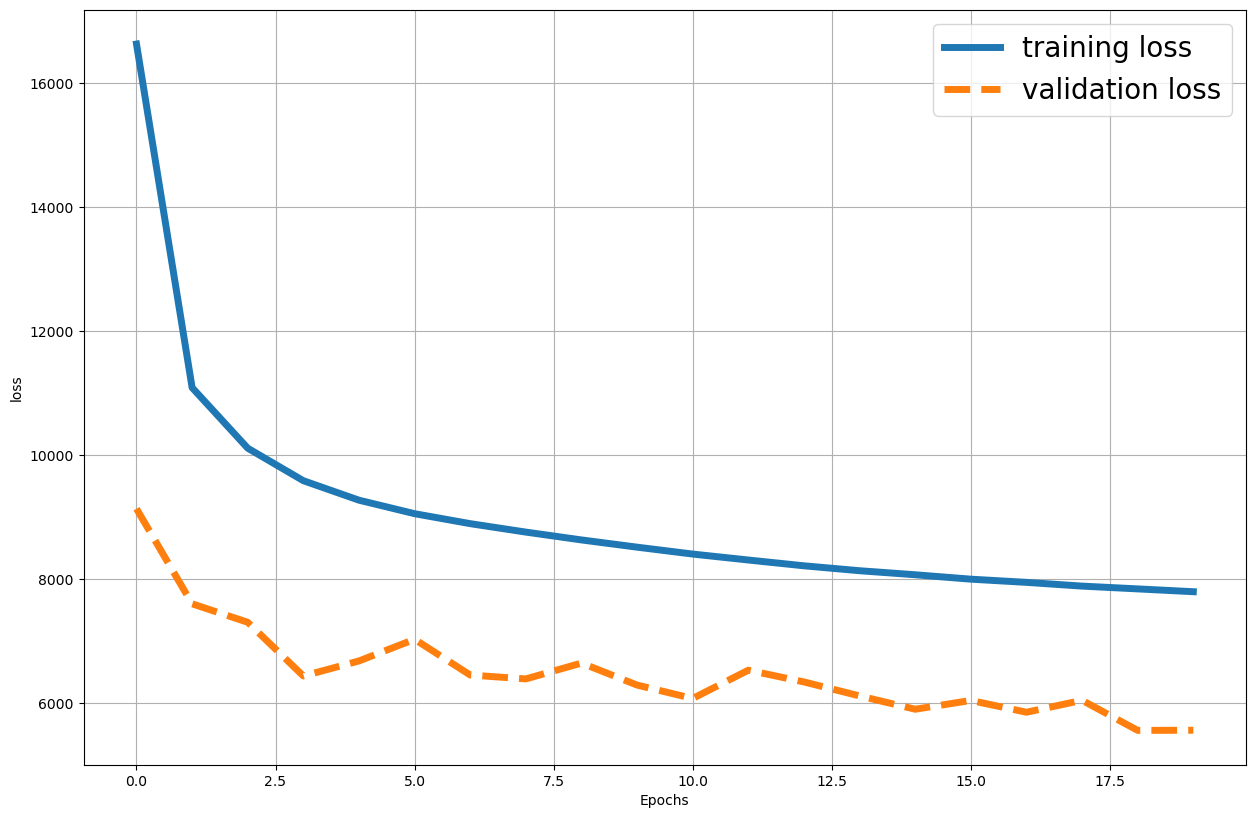

In [11]:
plt.figure(figsize=(15,10),dpi=100)
plt.plot(range(no_epochs), eval_dic['Loss_t'], 
         label='training loss', linewidth=5)
plt.plot(range(no_epochs), eval_dic['Loss_v'], 
         label='validation loss', linestyle='--', linewidth=5)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=0, prop={'size': 20})
# plt.

(b) [1 pt] Make the variational encoder predict the means of all the images in the test set
and visualize this latent space similarly as you did in Exercise 2(a).

In [12]:
from config_file import data_loc
from MNIST_dataloader import *
import matplotlib.cm as cm
import numpy as np

In [13]:
######################  Get the data  ##################################
# get dataloader
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = AE()
model_path = os.path.join("./", "Saved_ModelQ7.pth")
model.load_state_dict(torch.load(model_path))
# batch_size = 64
######### DEF PLOTTING LATENT
# model(x_clean.to(torch.device('cuda')))
# for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
def latent_plot(model, data, batch_size=64):
    # put the model in the correct device!
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)
    
    # make a rainbow_color space for the 10 classes
    color_list = cm.rainbow(np.linspace(0, 1, 10))
    k = 0
    for i, (x, y, label) in enumerate(data):
        # get the latent space from the encoder
        _,_,z = model.encoder(x.to(torch.device('cuda')))
        z = z.to(torch.device('cpu')).detach().numpy()
#         if i == 0: # for sanity check!!!!
        for j in range(len(z)):
#                 print(z[j][0][0],z[j][0][1],label[j].item())
#                 print(z[:,:,0])
            plt.scatter(z[:,0],z[:,1], c=label[:], cmap='tab10')
        if i == len(data)-1:
            print(len(z))
            plt.colorbar()
            break



Encoder working on cuda


16


Text(0, 0.5, ' Vertical')

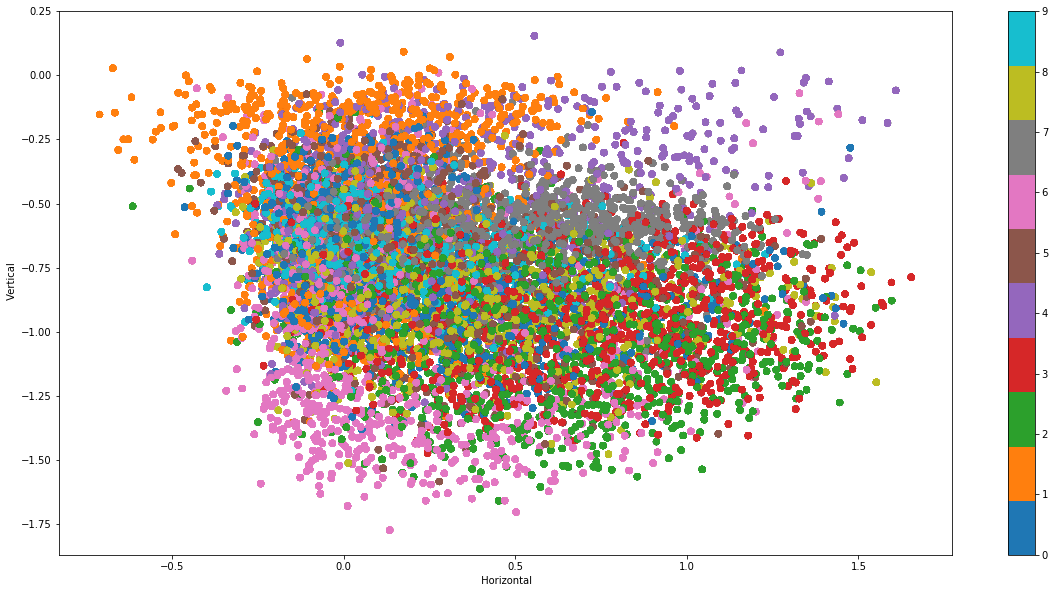

In [14]:
plt.figure(figsize=(20,10))
latent_plot(model, test_loader)
plt.xlabel(' Horizontal')
plt.ylabel(' Vertical')

In [5]:
# %% Create fucntion to sample from latent space

def sample(xmean: torch.Tensor, logstd: torch.Tensor) -> torch.Tensor:
    '''outputs a vector of the same length where v[k] = xmean[k] + n*std[k] 
    where n is sampled from the normal distribution'''

    assert xmean.size(0) == logstd.size(0), "Vectors of emans and standard deviations have different lengths" 
    l = xmean.size(0)
    n = np.random.rand(n)

    return xmean + n * torch.exp(logstd)

### Plot latent space

Encoder working on cuda


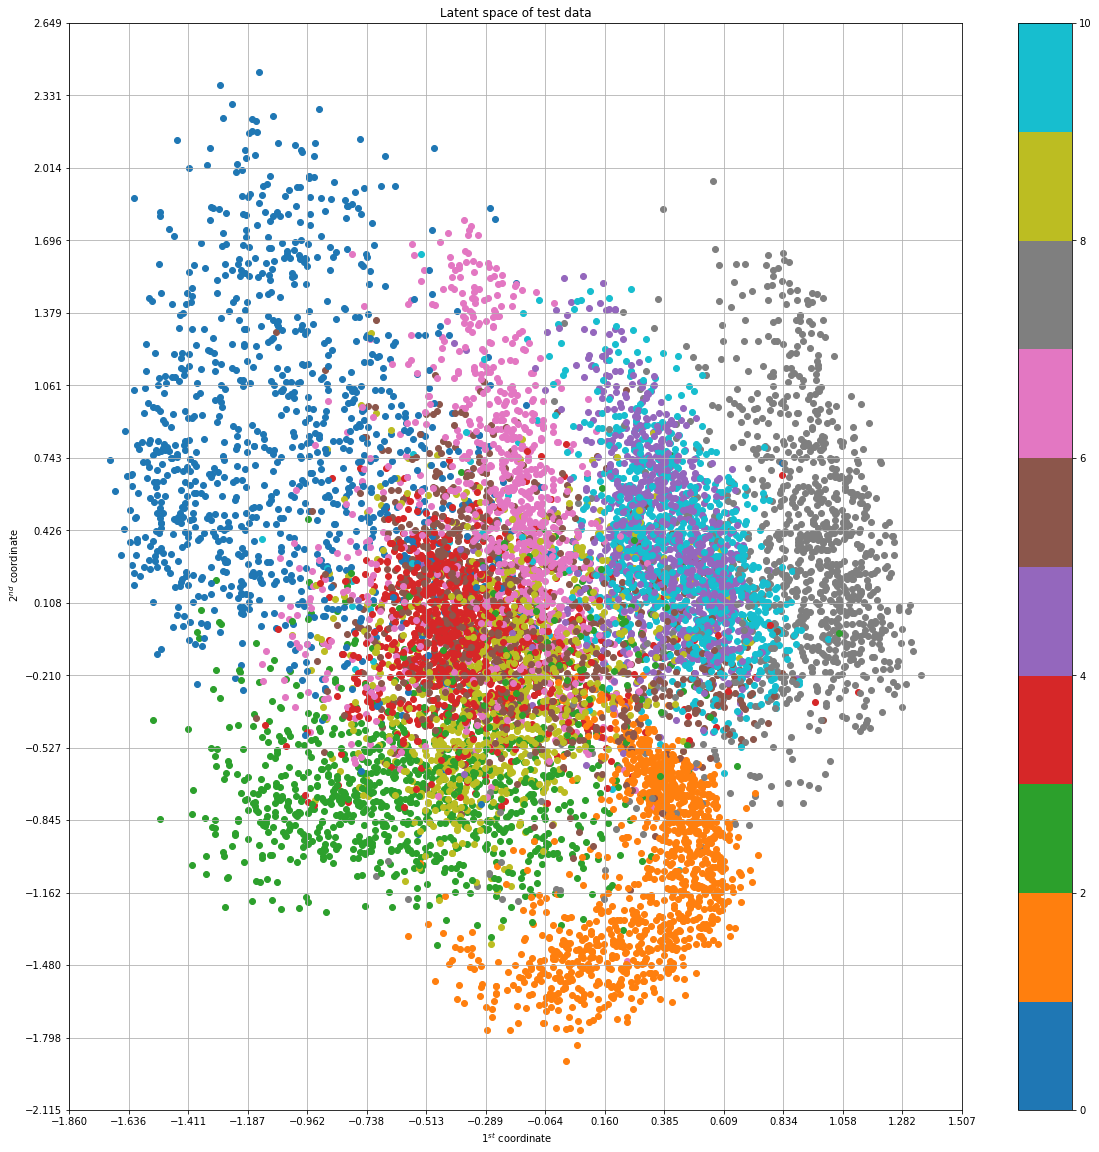

In [71]:
model = AE()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

_, test_loader, _ = MNIST_dataloader.create_dataloaders(data_loc, batch_size=1)

# iterate through the test dataset # plot latent space with grid on
color_list = cm.get_cmap()#cm.rainbow(np.linspace(0, 1, 10))
plt.figure(num=1, figsize=(20,20))
ax = plt.subplot(1,1,1)
norm = colors.Normalize(vmin=0, vmax=10, clip=True)

for clean_img, noisy_img, label in test_loader:
    # %% get latent space
    #mu, sigma, e, d = model.forward(clean_img)
    _, _, latent = model.encoder.forward(clean_img)
    X = latent[0,0].to('cpu').detach().numpy()
    Y = latent[0,1].to('cpu').detach().numpy()
    label = label.to('cpu').numpy()
    plt.scatter(X, Y, c=label, cmap='tab10', norm=norm)


plt.colorbar()
plt.xlabel(' $1^{st}$ coordinate')
plt.ylabel(' $2^{nd}$ coordinate')
plt.title("Latent space of test data")
ax.xaxis.set_major_locator(plticker.LinearLocator(16))
wheregridx = ax.xaxis.get_majorticklocs()
ax.yaxis.set_major_locator(plticker.LinearLocator(16))
wheregridy = ax.yaxis.get_majorticklocs()
plt.grid()
plt.show()



### Sample latent space

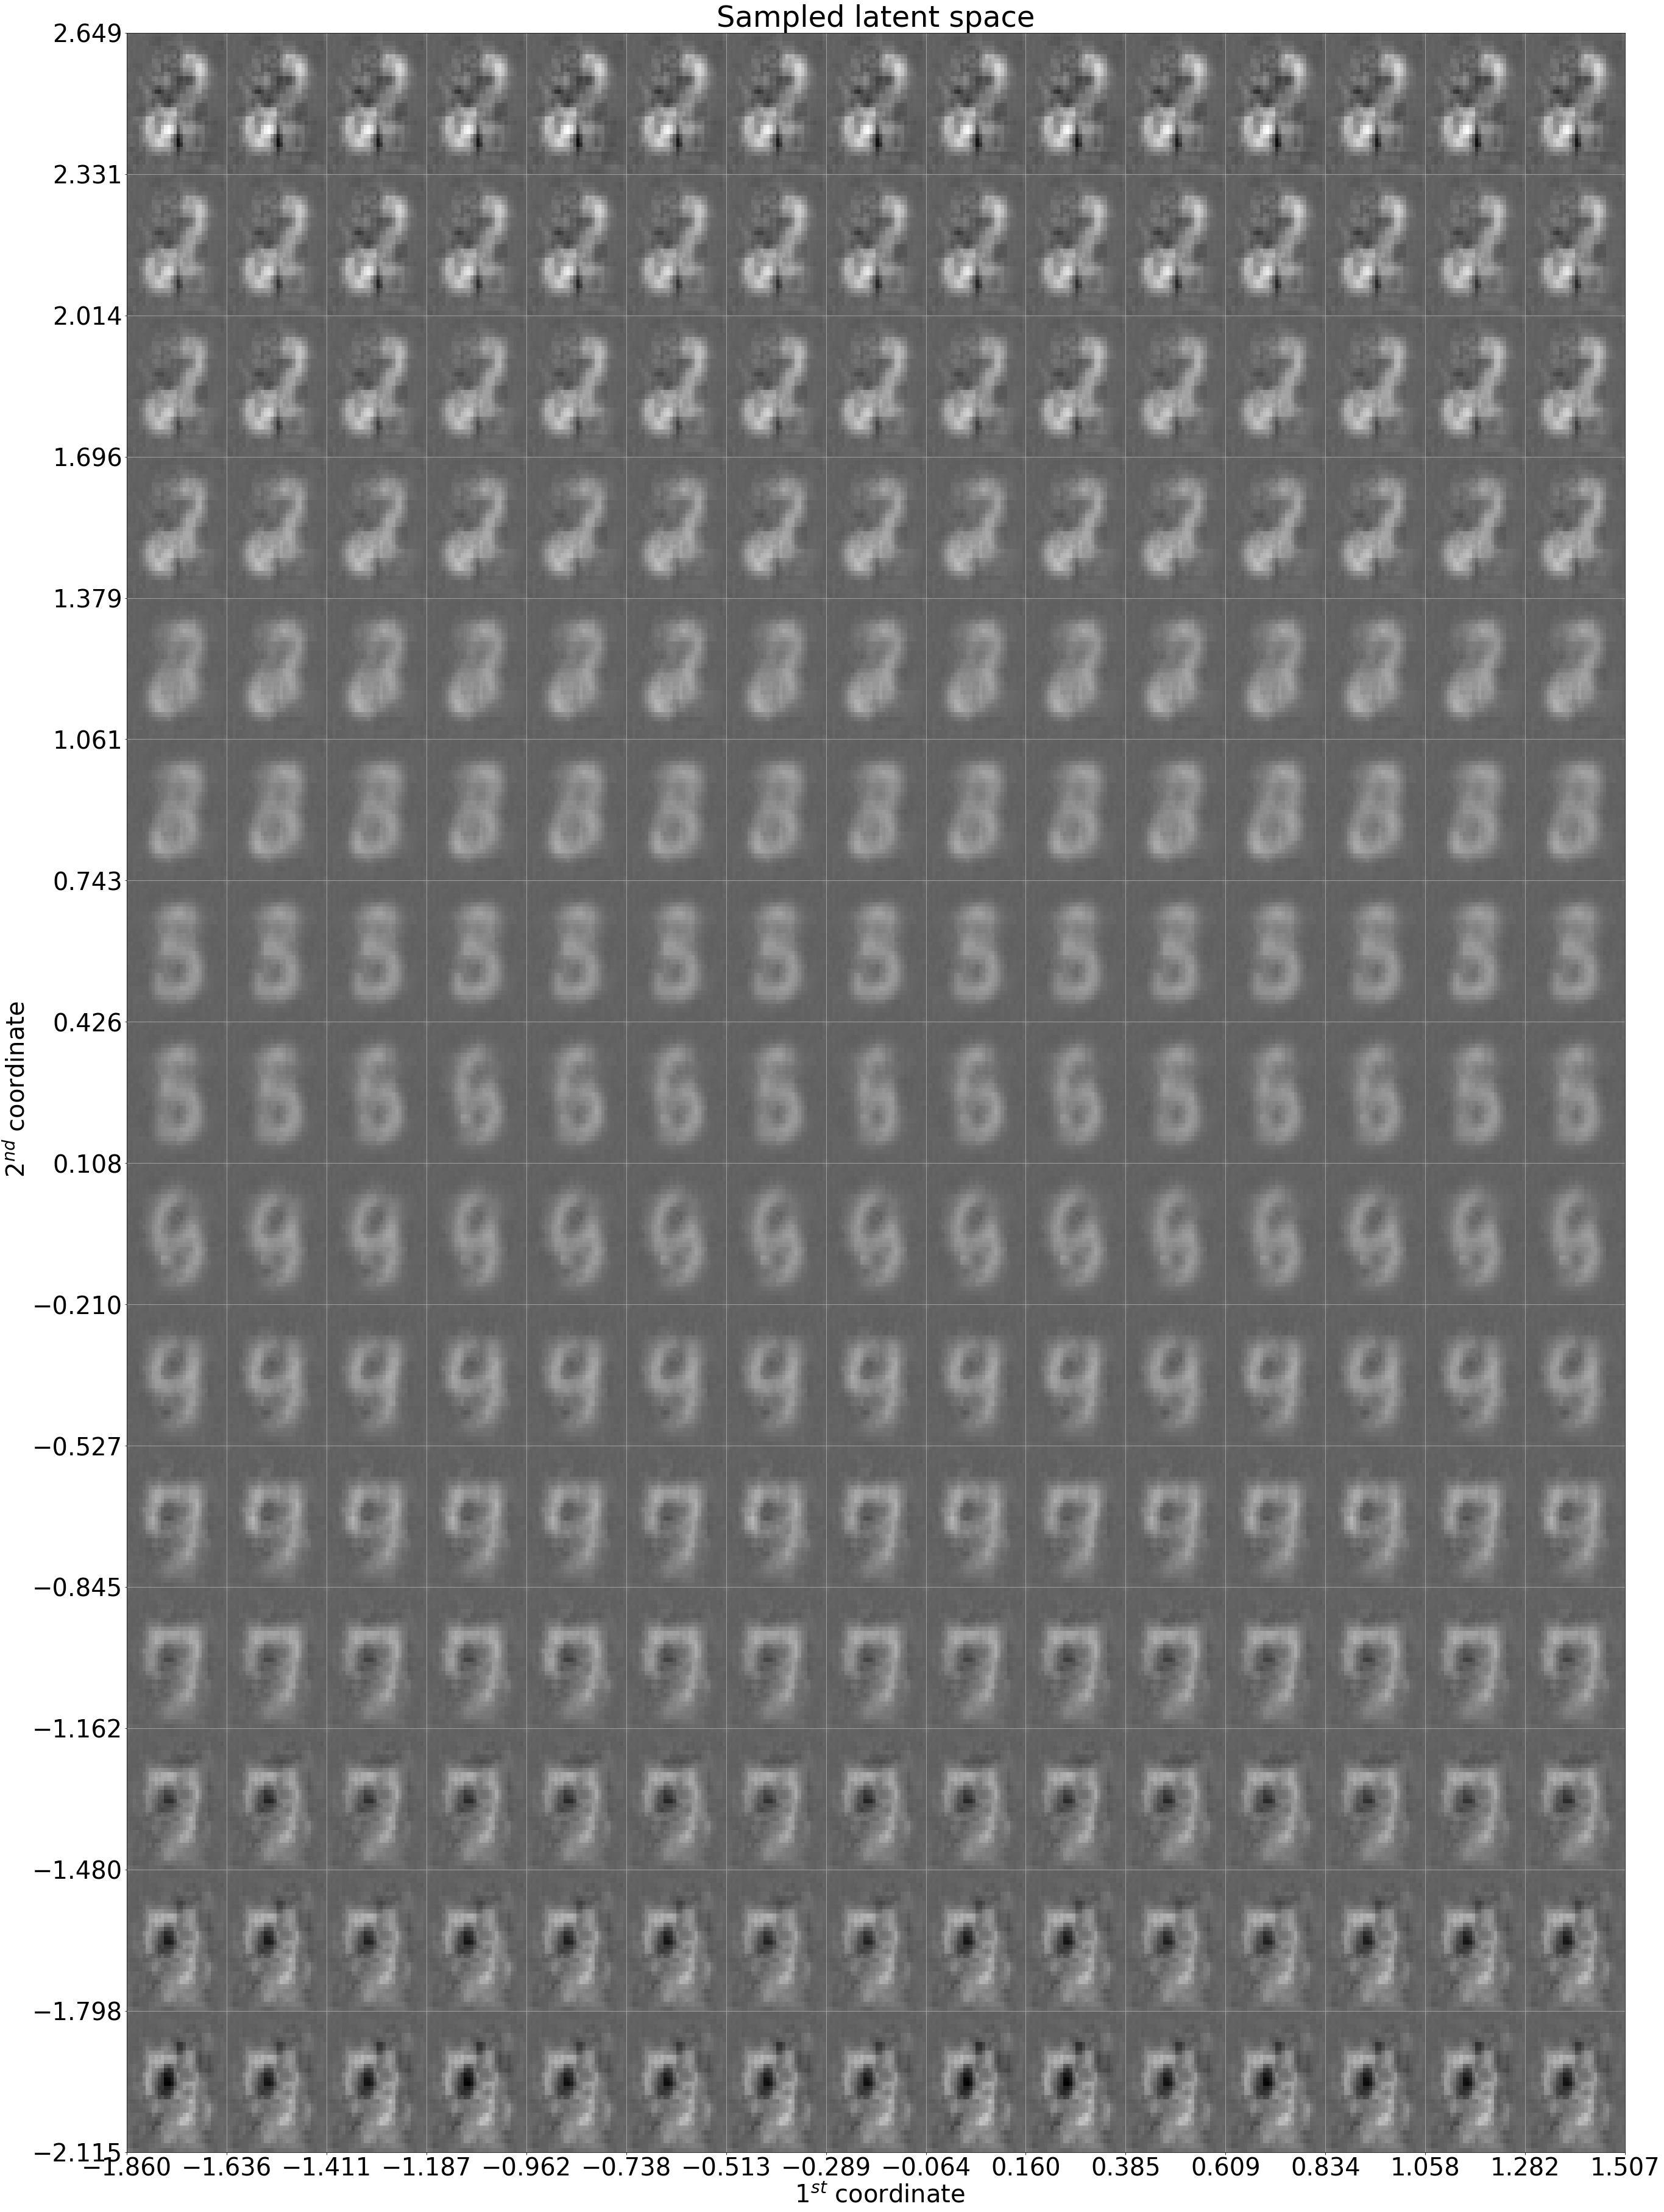

In [114]:
# %% sample data points from latent space

# fig, ax = plt.subplots(15,15)
# fig.set_figheight = 100
# fig.set_figwidth = 100
#plt.setp(ax, xlim=(wheregridx[0], wheregridx[-1]), ylim=(wheregridy[0], wheregridy[-1]))

bigplot = np.zeros((32*15,32*15))
sample = torch.zeros([15*15,1,1,2], dtype=torch.float32).to(device)
for i in range(len(wheregridx)-1):
    for j in range(len(wheregridx)-1):
        sample[i*15+j, 0, 0, 0] = np.random.uniform(low=wheregridx[i], high=wheregridx[i+1])
        sample[i*15+j, 0, 0, 1] = np.random.uniform(low=wheregridy[i], high=wheregridy[i+1])
        _,img = model.decoder.forward(sample[i*15+j,:,:,:].unsqueeze(0))
        bigplot[i*32:(i+1)*32, j*32:(j+1)*32] = img.squeeze().detach().numpy()
#         ax[i,j].imshow(img.squeeze().detach().numpy(), cmap='gray')#, extent=(wheregridx[i]*3, wheregridx[i+1]*3, wheregridy[j]*3, wheregridy[j+1]*3))
#         ax[i,j].axis('off')
#         ax[i,j].axvspan(xmin=wheregridx[i], xmax=wheregridx[i+1], ymin=wheregridy[j], ymax=wheregridx[j+1], color='g')


plt.figure(figsize=(64,64))
plt.rcParams.update({'font.size': 40})
ax = plt.subplot(1,1,1)
plt.title("Sampled latent space")
plt.xlabel(' $1^{st}$ coordinate')
plt.ylabel(' $2^{nd}$ coordinate')
plt.imshow(bigplot, cmap='gray',extent=(wheregridx[0], wheregridx[-1], wheregridy[0], wheregridy[-1]))
ax.xaxis.set_major_locator(plticker.LinearLocator(16))
ax.yaxis.set_major_locator(plticker.LinearLocator(16))
plt.grid()
plt.imsave(fname=os.path.join("./", "decodedlatent7.png"), arr=bigplot, cmap='gray')
plt.show()

### Denoise

Encoder working on cuda


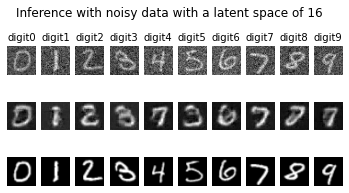

In [21]:
model = AE()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

_, test_loader, _ = MNIST_dataloader.create_dataloaders(data_loc, batch_size=1)

# load images
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]


# forward pass through the network / INFERENCE *suspicious look*
device = torch.device('cpu')
mu, sigma, latent, generated = model.forward(x_noisy_example)
mu, sigma, latent, generated_clean = model.forward(x_clean_example)
generated.to('cpu')



# plot
#plt.figure(figsize=(10,30))
for i in range(10):
    plt.subplot(4,10,i+1)
    plt.axis('off')
    plt.imshow(x_noisy_example[i,0,:,:].detach().numpy(), cmap='gray')
    plt.title("digit"+str(i), fontsize=10)
    plt.subplot(4,10,11+i)
    plt.axis('off')
    plt.imshow(generated[i,0,:,:].detach().numpy(), cmap='gray')
    plt.subplot(4,10,21+i)
    plt.axis('off')
    plt.imshow(x_clean_example[i,0,:,:].detach().numpy(), cmap='gray')
#     plt.subplot(4,10,31+i)
#     plt.axis('off')
#     plt.imshow(generated_clean[i,0,:,:].detach().numpy(), cmap='gray')

plt.subplots_adjust(hspace=0.1)
plt.suptitle("Inference with noisy data with a latent space of 16")
plt.show()

In [48]:
## Train again

encoder = model.encoder
decoder = model.decoder
train_loader, test_loader, val_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size=64)


class Optim(nn.Module):
    def __init__(self):
        super(Optim,self).__init__()  
        self.decoder=decoder.eval()
        self.beta = nn.parameter.Parameter(torch.ones(1))
        self.FC1 = nn.Linear(32*32, 16*16)
        self.FC2 = nn.Linear(16*16, 16)
        self.flatten= nn.Flatten()

    def forward(self, x):
        # First branch uses dilation
        out = self.flatten(x)
        out = self.FC1(out)
        out = self.FC2(out)
        b = self.beta*torch.sum(torch.square(out))#torch.square(torch.norm(out))
        g = self.decoder(out).to(device=device)
          
        return out, g, b, out


# %% training loop
argminn = Optim().train()
print("The training will start now!!!!!")
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []

# go over all epochs
for epoch in range(no_epochs):
    print(f"\nTraining Epoch {epoch}:")
    running_loss = 0.0
    # go over all minibatches
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        argminn.train()
        
        x_noisy =x_noisy.to(device=device, dtype=dtype)
        
        label = label.to(device=device, dtype=torch.int64)
        optimizer.zero_grad()

        out,g,b,_ = argminn(x_noisy)
#         print("x size", x_noisy.size())
#         print("g size", g.size())
#         print("b is ",b)
        loss = torch.sum(torch.square(x_noisy-g)) + b#torch.square(torch.norm(x_noisy-g)) + b
#         print("loss is ", torch.sum(torch.square(x_noisy-g))+b)
        loss.backward()
        optimizer.step()   
        
        running_loss += loss.item()

    # Check training loss
    train_epoch_loss = running_loss/len(train_loader)
    eval_dic['Loss_t'].append(train_epoch_loss)

    # Check validation loss
    with torch.no_grad():
        running_loss_val = 0.0
#         Set the model to evaluation mode
        argminn.eval()

        for (data_clean, data_noisy, labels) in val_loader:
            # validation on noisy part or not
            x = data_noisy

            # cast the inputs to the device
            x = x.to(device=device)
#             label = labels.to(device=device, dtype=torch.int64)
            
            out,g,b,_ = argminn(x)
            
            loss = torch.sum(torch.square(x-g)) + b
            running_loss_val += loss.item()

        val_epoch_loss = running_loss_val/len(val_loader)
        eval_dic['Loss_v'].append(val_epoch_loss)

    print('Epoch', epoch)
    print('Training Loss', eval_dic['Loss_t'][epoch])
    print('Validation Loss', eval_dic['Loss_v'][epoch])

    
model_path = os.path.join("./", "Saved_argminQ8.pth")
torch.save(model.state_dict(), model_path)

  0%|          | 1/844 [00:00<01:27,  9.64it/s]

The training will start now!!!!!

Training Epoch 0:


  7%|▋         | 60/844 [00:05<01:05, 11.89it/s]


KeyboardInterrupt: 